In [17]:
import pandas as pd
import numpy as np


df = pd.read_parquet( "../Src/EURUSD15.parquet", engine="pyarrow")
raw_OHLC_1M = pd.read_parquet( "../Src/EURUSD1.parquet", engine="pyarrow")



print(df.shape)
print(raw_OHLC_1M.shape)

(174598, 6)
(156595, 6)


In [18]:
import pandas as pd
from datetime import datetime
from typing import Union, Optional

def filter_by_date(
    df: pd.DataFrame,
    start_date: Union[str, datetime],
    end_date: Union[str, datetime],
    datetime_col: str = 'datetime',
    inclusive: str = 'both'
) -> pd.DataFrame:
    """
    Filters a DataFrame by a date range with robust error handling and flexible inclusivity.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the datetime column.
        start_date (str or datetime): Start of the date range.
        end_date (str or datetime): End of the date range.
        datetime_col (str, optional): Name of the datetime column in df. Defaults to 'datetime'.
        inclusive (str, optional): Boundary inclusion behavior ('both', 'left', 'right', 'neither').
                                  Defaults to 'both'.

    Returns:
        pd.DataFrame: Filtered DataFrame containing rows within the specified date range.

    Raises:
        ValueError: If inputs are invalid or datetime conversion fails.
        KeyError: If datetime_col is not found in the DataFrame.
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame")

    if datetime_col not in df.columns:
        raise KeyError(f"Column '{datetime_col}' not found in DataFrame")

    if inclusive not in {'both', 'left', 'right', 'neither'}:
        raise ValueError("inclusive must be one of 'both', 'left', 'right', 'neither'")

    try:
        # Convert dates to datetime if they aren't already
        start_dt = pd.to_datetime(start_date)
        end_dt = pd.to_datetime(end_date)
    except Exception as e:
        raise ValueError(f"Failed to convert dates to datetime: {str(e)}")

    # Validate date range
    if start_dt > end_dt:
        raise ValueError("start_date must be earlier than or equal to end_date")

    # Ensure datetime column is datetime type
    try:
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    except Exception as e:
        raise ValueError(f"Failed to convert '{datetime_col}' to datetime: {str(e)}")

    # Check for invalid datetime entries
    if df[datetime_col].isna().any():
        print(f"Warning: Some entries in '{datetime_col}' could not be converted to datetime and will be excluded")

    # Filter rows based on inclusivity
    mask = True
    if inclusive == 'both':
        mask = (df[datetime_col] >= start_dt) & (df[datetime_col] <= end_dt)
    elif inclusive == 'left':
        mask = (df[datetime_col] >= start_dt) & (df[datetime_col] < end_dt)
    elif inclusive == 'right':
        mask = (df[datetime_col] > start_dt) & (df[datetime_col] <= end_dt)
    elif inclusive == 'neither':
        mask = (df[datetime_col] > start_dt) & (df[datetime_col] < end_dt)

    # Use copy to avoid SettingWithCopyWarning and improve memory efficiency
    filtered_df = df[mask].copy()

    # Reset index if needed (optional, depending on use case)
    # filtered_df = filtered_df.reset_index(drop=True)

    return filtered_df

In [19]:
dta_1min_1M = filter_by_date(raw_OHLC_1M, '2025-05-01', '2025-06-01')
dta_1min_1M.set_index('datetime', inplace=True)


ohlc_1M_1, ohlc_1M_2, ohlc_1M_3, ohlc_1M_4 = np.array_split(dta_1min_1M, 4)
ohlc_1M_M, ohlc_1M_T, ohlc_1M_TH, ohlc_1M_W, ohlc_1M_F, ohlc_1M_S = np.array_split(ohlc_1M_1, 6)


print (ohlc_1M_M)

/home/avijit/PY.dev/dev.Chartter.v2/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


                        open     high      low    close  vol
datetime                                                    
2025-05-01 00:00:00  1.13221  1.13265  1.13220  1.13251  102
2025-05-01 00:01:00  1.13252  1.13277  1.13252  1.13256   72
2025-05-01 00:02:00  1.13259  1.13259  1.13229  1.13241   90
2025-05-01 00:03:00  1.13241  1.13260  1.13237  1.13253   46
2025-05-01 00:04:00  1.13252  1.13263  1.13249  1.13255   27
...                      ...      ...      ...      ...  ...
2025-05-01 21:46:00  1.12884  1.12884  1.12870  1.12883   10
2025-05-01 21:47:00  1.12883  1.12884  1.12883  1.12883    3
2025-05-01 21:48:00  1.12877  1.12877  1.12876  1.12876    9
2025-05-01 21:49:00  1.12875  1.12884  1.12874  1.12884   11
2025-05-01 21:50:00  1.12873  1.12873  1.12873  1.12873    9

[1311 rows x 5 columns]


In [20]:

dta_1y = filter_by_date(df, '2024-01-01', '2025-01-01')
dta_1y.set_index('datetime', inplace=True)

ohlc_4H = dta_1y.resample('4h').agg({
    'open': 'first',    # first value in 4H
    'high': 'max',      # max in 4H
    'low': 'min',       # min in 4H
    'close': 'last',    # last value in 4H
    'vol': 'sum'        # sum of volume
})

print(ohlc_4H)


                        open     high      low    close    vol
datetime                                                      
2024-01-01 20:00:00  1.10427  1.10447  1.10356  1.10365   3928
2024-01-02 00:00:00  1.10366  1.10432  1.10176  1.10245  24507
2024-01-02 04:00:00  1.10245  1.10380  1.10151  1.10153  30175
2024-01-02 08:00:00  1.10156  1.10387  1.09665  1.09690  70044
2024-01-02 12:00:00  1.09691  1.09717  1.09410  1.09435  86417
...                      ...      ...      ...      ...    ...
2024-12-31 04:00:00  1.04084  1.04129  1.03996  1.04118  12253
2024-12-31 08:00:00  1.04120  1.04243  1.04051  1.04103  33697
2024-12-31 12:00:00  1.04103  1.04143  1.03525  1.03547  76538
2024-12-31 16:00:00  1.03548  1.03646  1.03440  1.03547  30185
2024-12-31 20:00:00  1.03547  1.03630  1.03526  1.03526   4499

[2191 rows x 5 columns]


In [21]:
dta_1m = filter_by_date(df, '2024-11-01', '2024-12-01')
dta_1m.set_index('datetime', inplace=True)

ohlc_1H = dta_1m.resample('1h').agg({
    'open': 'first',    # first value in 4H
    'high': 'max',      # max in 4H
    'low': 'min',       # min in 4H
    'close': 'last',    # last value in 4H
    'vol': 'sum'        # sum of volume
})

print(ohlc_1H)

                        open     high      low    close    vol
datetime                                                      
2024-11-01 00:00:00  1.08838  1.08874  1.08804  1.08866   6397
2024-11-01 01:00:00  1.08866  1.08885  1.08785  1.08798  12821
2024-11-01 02:00:00  1.08799  1.08811  1.08765  1.08782  10538
2024-11-01 03:00:00  1.08783  1.08789  1.08751  1.08763   7541
2024-11-01 04:00:00  1.08762  1.08789  1.08757  1.08770   4676
...                      ...      ...      ...      ...    ...
2024-11-29 17:00:00  1.05465  1.05678  1.05435  1.05673  15585
2024-11-29 18:00:00  1.05674  1.05781  1.05674  1.05753  14734
2024-11-29 19:00:00  1.05753  1.05800  1.05722  1.05795  11794
2024-11-29 20:00:00  1.05796  1.05843  1.05781  1.05823  11750
2024-11-29 21:00:00  1.05822  1.05830  1.05747  1.05748   9265

[694 rows x 5 columns]


In [22]:


ohlc_15M_1, ohlc_15M_2, ohlc_15M_3, ohlc_15M_4 = np.array_split(dta_1m, 4)

print (ohlc_15M_1)

                        open     high      low    close   vol
datetime                                                     
2024-11-01 00:00:00  1.08838  1.08843  1.08809  1.08823  2128
2024-11-01 00:15:00  1.08824  1.08826  1.08804  1.08812  1491
2024-11-01 00:30:00  1.08811  1.08845  1.08805  1.08845   845
2024-11-01 00:45:00  1.08844  1.08874  1.08844  1.08866  1933
2024-11-01 01:00:00  1.08866  1.08885  1.08859  1.08880  1876
...                      ...      ...      ...      ...   ...
2024-11-08 05:00:00  1.07828  1.07839  1.07816  1.07832  2168
2024-11-08 05:15:00  1.07835  1.07863  1.07826  1.07843  2122
2024-11-08 05:30:00  1.07843  1.07853  1.07809  1.07820  1930
2024-11-08 05:45:00  1.07818  1.07850  1.07799  1.07817  2159
2024-11-08 06:00:00  1.07819  1.07837  1.07765  1.07766  3863

[501 rows x 5 columns]


/home/avijit/PY.dev/dev.Chartter.v2/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [23]:
import logging
import pandas as pd
import mplfinance as mpf
from typing import List, Optional, Dict, Any, Union
from uuid import uuid4
from datetime import datetime

# Configure logging for enterprise use
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('chartter.log')  # Log to file for auditing
    ]
)
logger = logging.getLogger(__name__)

class Chartter:
    """Simple, industry-level financial charting utility using mplfinance for OHLCV data visualization."""

    def __init__(self, config: Optional[Dict[str, Any]] = None):
        """
        Initialize Chartter with default or custom configuration.

        Args:
            config (Dict[str, Any], optional): Custom configuration for charting.
        """
        self._default_config = {
            'chart_type': 'candle',
            'style': 'charles',
            'title': 'Financial Chart',
            'ylabel': 'Price',
            'ylabel_lower': 'Volume',
            'xlabel': 'Date',
            'figratio': (16, 5),
            'panel_ratios': (3, 1),
            'datetime_format': '%Y-%m-%d %H:%M',
            'xrotation': 20,
            'volume': True,  # Toggle to show/hide volume
            'volume_panel': 1,  # Default panel for volume when enabled
            'warn_too_much_data': 10000,
            'width_config': {
                'candle_linewidth': 1.0,
                'candle_width': 0.6,
                'ohlc_linewidth': 1.0,
                'volume_linewidth': 1.0
            },
            'savefig': None  # Path to save chart (e.g., 'chart.png')
        }
        self.config = self._default_config if config is None else {**self._default_config, **config}
        self._validate_config()

    def _validate_config(self) -> None:
        """Validate configuration parameters."""
        valid_chart_types = ['candle', 'ohlc', 'line', 'renko', 'pnf']
        if self.config['chart_type'] not in valid_chart_types:
            logger.error(f"Invalid chart_type: {self.config['chart_type']}. Must be one of {valid_chart_types}")
            raise ValueError(f"chart_type must be one of {valid_chart_types}")

        if not isinstance(self.config['figratio'], tuple) or len(self.config['figratio']) != 2:
            logger.error("figratio must be a tuple of (width, height)")
            raise ValueError("figratio must be a tuple of (width, height)")

        if self.config['savefig'] is not None:
            if not isinstance(self.config['savefig'], str):
                logger.error("savefig must be a string path (e.g., 'chart.png')")
                raise ValueError("savefig must be a string path")
            if not self.config['savefig'].endswith(('.png', '.jpg', '.pdf')):
                logger.error("savefig must have a valid extension (.png, .jpg, .pdf)")
                raise ValueError("savefig must have a valid extension (.png, .jpg, .pdf)")

        if not isinstance(self.config['volume'], bool):
            logger.error("volume must be a boolean (True/False)")
            raise ValueError("volume must be a boolean (True/False)")

        if self.config['volume'] and self.config['volume_panel'] < 0:
            logger.error("volume_panel must be non-negative when volume is True")
            raise ValueError("volume_panel must be non-negative when volume is True")

    def _validate_dataframe(self, df: pd.DataFrame, volume_enabled: bool) -> None:
        """Validate input DataFrame for required OHLCV columns and datetime index."""
        if not isinstance(df, pd.DataFrame):
            logger.error("Input must be a pandas DataFrame")
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = ['open', 'high', 'low', 'close']
        if not all(col in df.columns for col in required_columns):
            logger.error(f"DataFrame must contain columns: {required_columns}")
            raise ValueError(f"DataFrame must contain columns: {required_columns}")

        if not pd.api.types.is_datetime64_any_dtype(df.index):
            logger.error("DataFrame index must be datetime")
            raise ValueError("DataFrame index must be datetime")

        if volume_enabled and 'Volume' not in df.columns:
            logger.error("DataFrame must contain 'Volume' column when volume is True")
            raise ValueError("DataFrame must contain 'Volume' column when volume is True")

        if len(df) > self.config['warn_too_much_data']:
            logger.warning(f"DataFrame contains {len(df)} rows, exceeding warn_too_much_data threshold of {self.config['warn_too_much_data']}")

    def _validate_addplot(self, addplot: Optional[Union[Dict, List[Dict]]], df: pd.DataFrame) -> Optional[List[Dict]]:
        """Validate addplot and ensure data aligns with DataFrame index."""
        if addplot is None:
            return None

        # Convert single dict to list for consistency
        validated_addplot = [addplot] if isinstance(addplot, dict) else addplot
        if not isinstance(validated_addplot, list) or not all(isinstance(item, dict) for item in validated_addplot):
            logger.error("addplot must be a dict or list of dicts")
            raise ValueError("addplot must be a dict or list of dicts")

        # Validate that addplot data aligns with df index
        for ap in validated_addplot:
            if 'data' not in ap:
                continue  # Some addplots (e.g., vlines) may not have 'data'
            ap_data = ap['data']
            if isinstance(ap_data, pd.Series):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            elif isinstance(ap_data, pd.DataFrame):
                if not ap_data.index.equals(df.index):
                    logger.error(f"addplot data index does not match DataFrame index. Expected length {len(df)}, got {len(ap_data)}")
                    raise ValueError(f"addplot data index must match DataFrame index")
            else:
                logger.warning("addplot 'data' should be a pandas Series or DataFrame for index validation")

        return validated_addplot

    def plot(
        self,
        df: pd.DataFrame,
        addplot: Optional[Union[Dict, List[Dict]]] = None,
        config: Optional[Dict[str, Any]] = None
    ) -> None:
        """
        Plot financial chart with OHLCV data and optional additional plots.

        Args:
            df (pd.DataFrame): DataFrame with OHLCV data and datetime index.
            addplot (Dict or List[Dict], optional): Additional plots (mpf.make_addplot).
            config (Dict[str, Any], optional): Override default configuration for this plot.

        Raises:
            ValueError: If DataFrame, addplot, or configuration is invalid.
        """
        start_time = datetime.now()
        chart_id = str(uuid4())
        logger.info(f"Generating chart {chart_id} with {len(df)} data points")

        try:
            # Merge custom config with instance config
            plot_config = self.config.copy()
            if config:
                plot_config.update(config)
                self._validate_config()

            # Validate input DataFrame
            self._validate_dataframe(df, volume_enabled=plot_config['volume'])

            # Validate addplot and ensure index alignment
            validated_addplot = self._validate_addplot(addplot, df)

            # Adjust volume_panel and panel_ratios dynamically
            if validated_addplot:
                max_panel = max([ap.get('panel', 0) for ap in validated_addplot], default=0)
                if plot_config['volume']:
                    plot_config['volume_panel'] = max(max_panel + 1, 1)  # Place volume after highest addplot panel
                panel_ratios = tuple([3] + [1] * max(max_panel, plot_config['volume_panel'] if plot_config['volume'] else 0))
            else:
                panel_ratios = (3,) if not plot_config['volume'] else plot_config['panel_ratios']
                if plot_config['volume'] and plot_config['volume_panel'] > 1:
                    plot_config['volume_panel'] = 1  # Reset to avoid missing panels

            # Prepare plot arguments
            plot_kwargs = {
                'type': plot_config['chart_type'],
                'style': plot_config['style'],
                'volume': plot_config['volume'],
                'title': plot_config['title'],
                'ylabel': plot_config['ylabel'],
                'xlabel': plot_config['xlabel'],
                'figratio': plot_config['figratio'],
                'panel_ratios': panel_ratios,
                'tight_layout': True,
                'datetime_format': plot_config['datetime_format'],
                'xrotation': plot_config['xrotation'],
                'warn_too_much_data': plot_config['warn_too_much_data'],
                'update_width_config': plot_config['width_config']
            }

            # Only include volume_panel and ylabel_lower if volume is enabled
            if plot_config['volume']:
                plot_kwargs['volume_panel'] = plot_config['volume_panel']
                plot_kwargs['ylabel_lower'] = plot_config['ylabel_lower']

            # Only include addplot if valid
            if validated_addplot:
                plot_kwargs['addplot'] = validated_addplot

            # Add savefig if specified
            if plot_config['savefig']:
                plot_kwargs['savefig'] = plot_config['savefig']

            # Plot the chart
            mpf.plot(df, **plot_kwargs)
            logger.info(f"Chart {chart_id} generated successfully in {(datetime.now() - start_time).total_seconds():.2f}s")

            # Log file save if applicable
            if plot_config['savefig']:
                logger.info(f"Chart saved to {plot_config['savefig']}")

        except Exception as e:
            logger.error(f"Failed to generate chart {chart_id}: {str(e)}")
            raise

2025-09-21 17:44:04,162 [INFO] Generating chart b964620a-d241-4166-9238-5dcf12d79add with 2191 data points


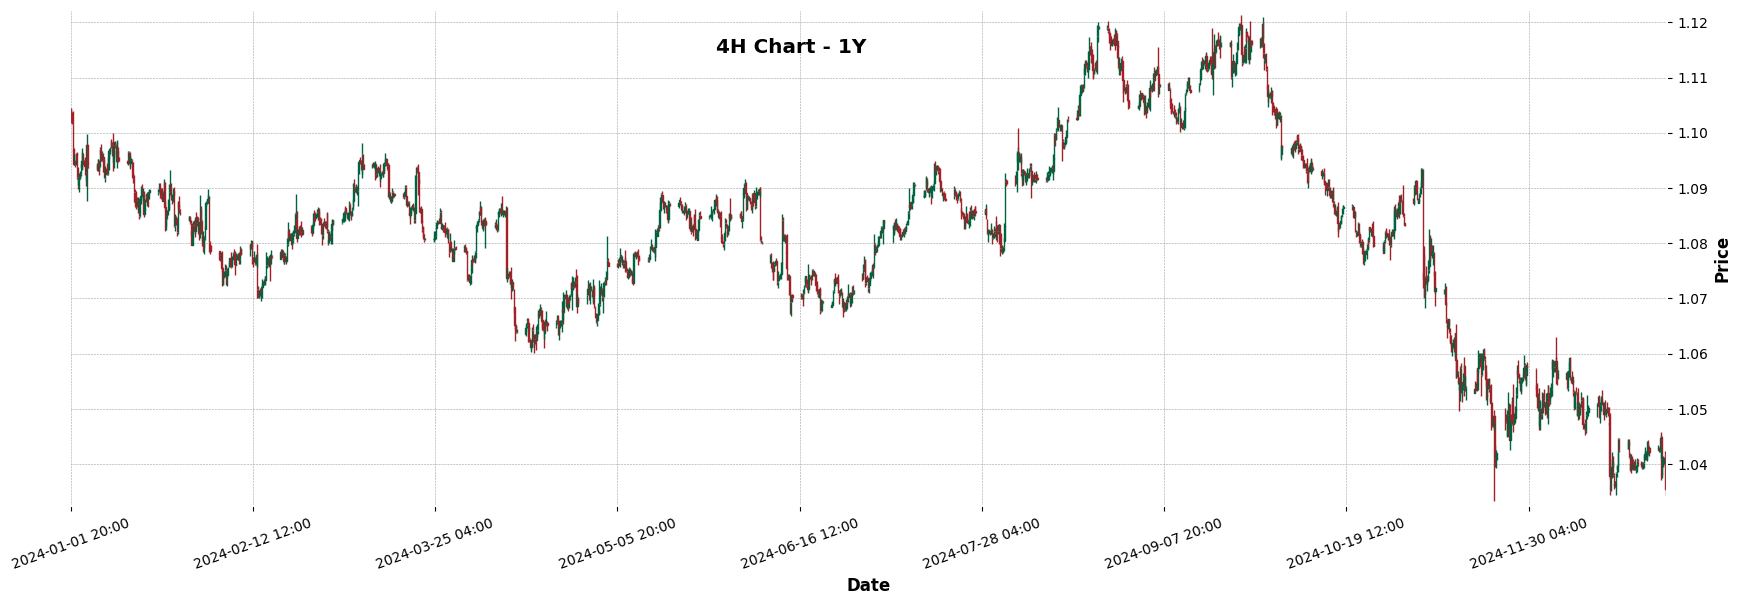

2025-09-21 17:44:06,733 [INFO] Chart b964620a-d241-4166-9238-5dcf12d79add generated successfully in 2.57s
2025-09-21 17:44:06,993 [INFO] Generating chart d5644605-ac27-4286-811a-5477562c09b9 with 694 data points


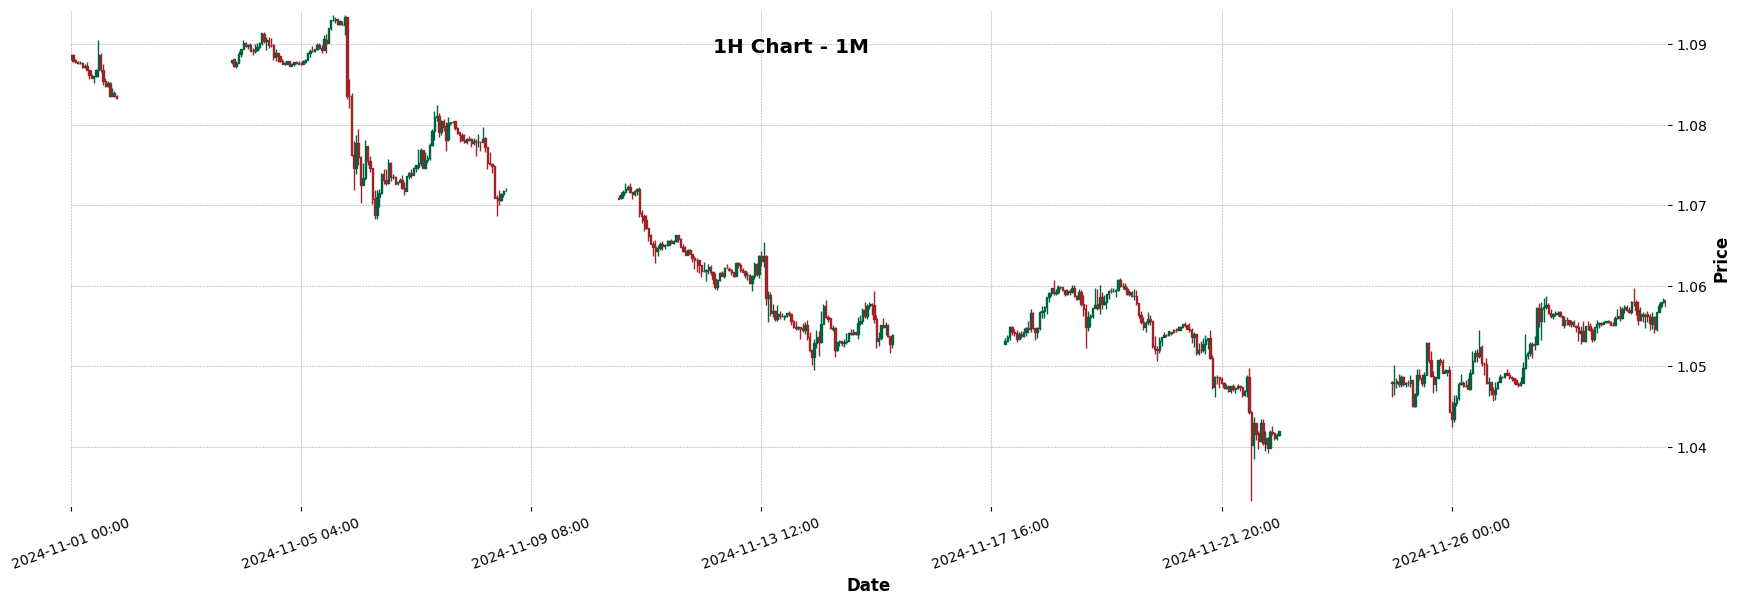

2025-09-21 17:44:07,620 [INFO] Chart d5644605-ac27-4286-811a-5477562c09b9 generated successfully in 0.63s
2025-09-21 17:44:07,777 [INFO] Generating chart 2fc6d05c-efbb-4f1d-9a10-e5ff6bc9aec7 with 501 data points


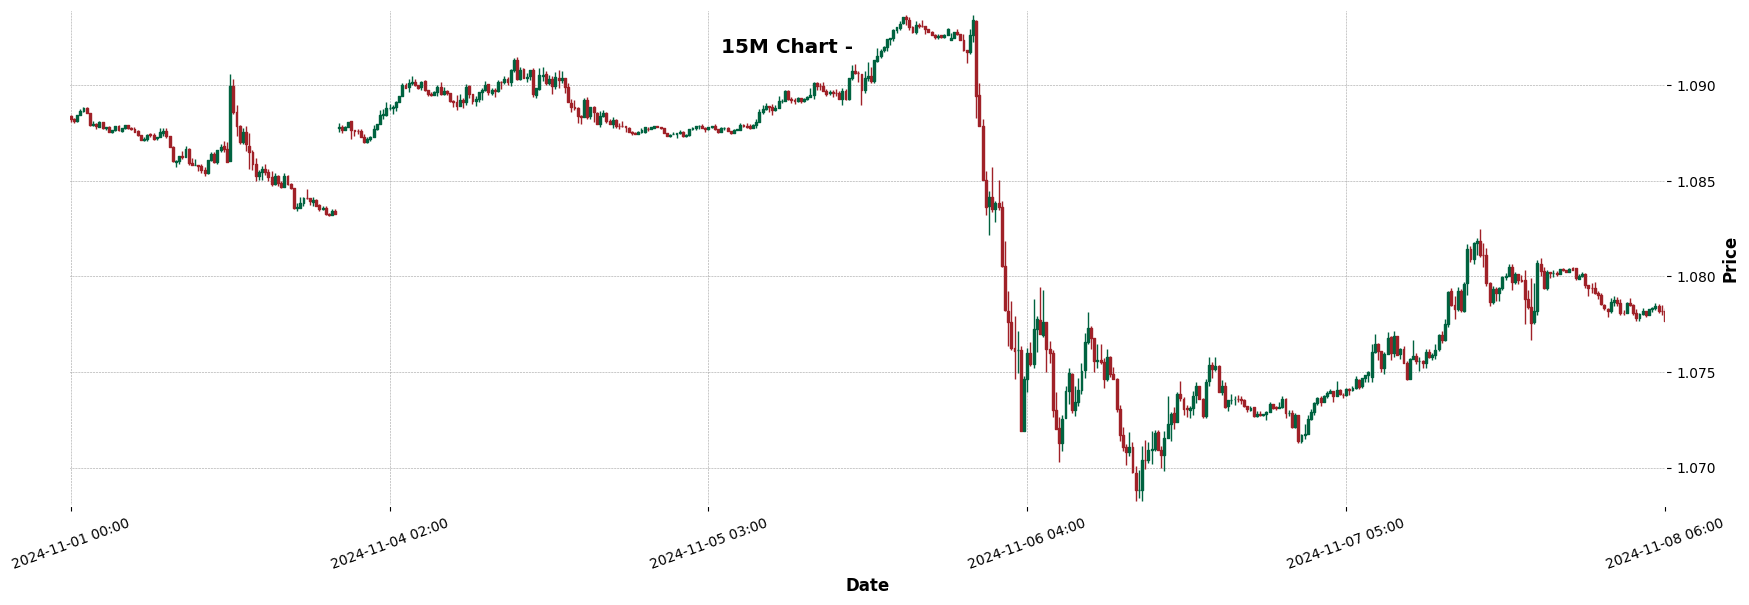

2025-09-21 17:44:08,817 [INFO] Chart 2fc6d05c-efbb-4f1d-9a10-e5ff6bc9aec7 generated successfully in 1.04s
2025-09-21 17:44:08,821 [INFO] Generating chart 383a5f93-97de-4b23-a4a7-95649cf90835 with 1311 data points


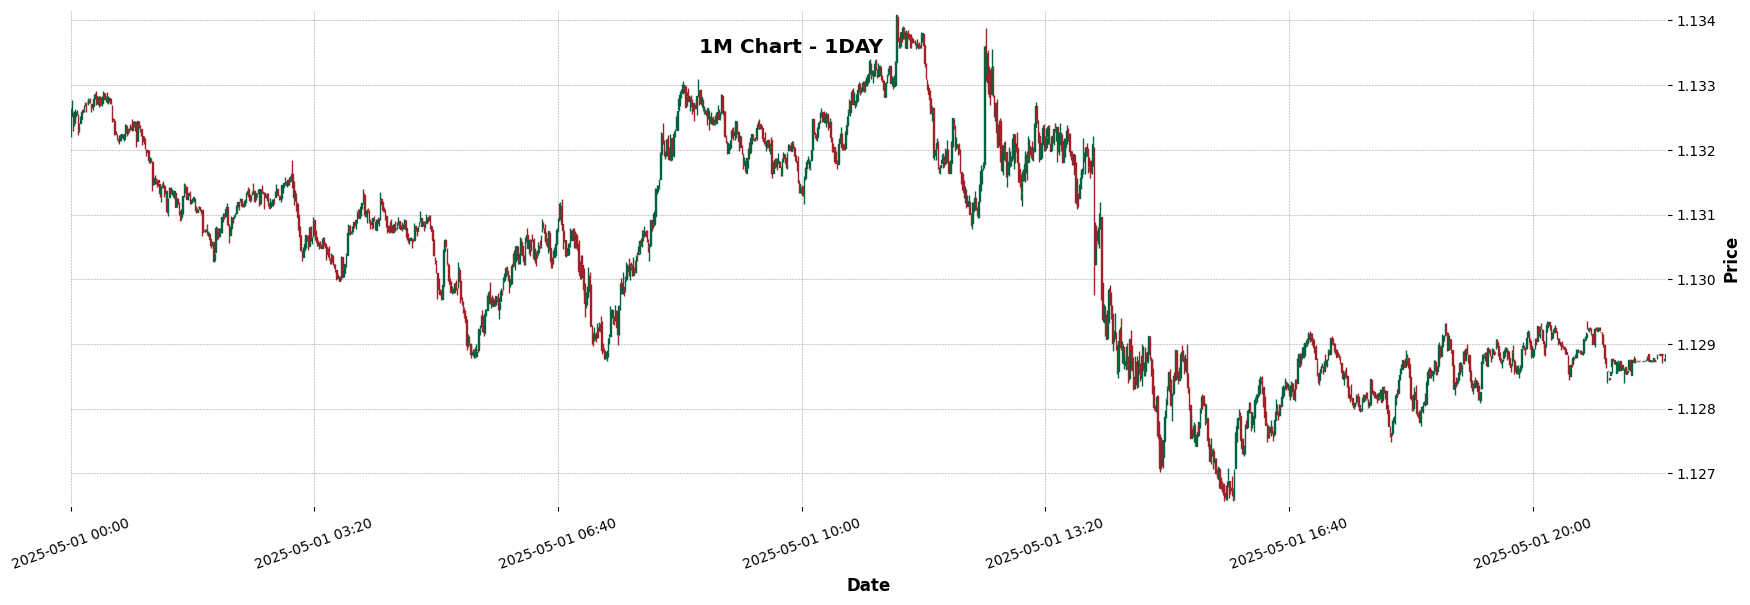

2025-09-21 17:44:09,420 [INFO] Chart 383a5f93-97de-4b23-a4a7-95649cf90835 generated successfully in 0.60s


In [24]:
# Initialize Chartter with custom config
chartter = Chartter(config={
            # 'chart_type': 'candle',
            # 'style': 'charles',
            'volume': False,
            # 'volume_panel': 1
            # 'savefig': None  # Path to save chart (e.g., 'chart.png')
        })

# Plot without additional plots
chartter.plot(ohlc_4H,config={'title':'4H Chart - 1Y'})
chartter.plot(ohlc_1H,config={'title':'1H Chart - 1M'})
chartter.plot(ohlc_15M_1,config={'title':'15M Chart - '})
chartter.plot(ohlc_1M_M,config={'title':'1M Chart - 1DAY'})

# Plot with a custom additional plot, ensuring index alignment

# chartter.plot(ohlc_4H.iloc[100:251], addplot=[
#     mpf.make_addplot(ohlc_4H.iloc[100:251]['Close'].rolling(10).mean(), color='orange', label='SMA(10)', panel=1)
#     ])